In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 
import wisps.simulations.effective_numbers as eff
import seaborn as sns
import matplotlib
import popsims
import itertools
#plt.style.use('dark_background')


%matplotlib inline

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
 wispsim.MAG_LIMITS

{'wisps': {'F110': (poly1d([ 1.20489888, 18.31086895]), 0.5038943667884174),
  'F140': (poly1d([ 1.49122797, 17.14118556]), 0.7495636144809823),
  'F160': (poly1d([ 1.36561328, 17.37352631]), 1.4165037712823727)},
 'hst3d': {'F110': (None, nan),
  'F140': (poly1d([-0.10025015, 22.66882951]), 0.21335391346949473),
  'F160': (poly1d([ 0.14320198, 21.86199263]), 0.22142403753971857)},
 'ncutoff': 50,
 'snr_exp': {'F110': [-0.325132443138751,
   0.45581918736688865,
   1.7415826812146138,
   19.0],
  'F140': [-0.29813184509194934, 0.3806309280542064, 1.6254519593166021, 19.0],
  'F160': [-0.3052935624170122,
   0.44311870393629726,
   1.6002181916033673,
   19.0]},
 'mag_unc_exp': {'F110': [19.0,
   -0.34825934107482936,
   0.25411795542413473,
   -2.6922918095792334],
  'F140': [19.0,
   -0.4297747738627907,
   0.25976823435662977,
   -2.4103106665996568],
  'F160': [19.0,
   -0.34825934107482936,
   0.25131407450441023,
   -2.3670766523352955]},
 'F110': (poly1d([ 1.20489888, 18.31086895

In [3]:
import popsims
import splat

In [4]:
sgrid=wispsim.SPGRID
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 
#klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
#klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
#klf=klf.replace(0.0,np.nan)

ucds=pd.read_pickle(wisps.LIBRARIES+'/new_real_ucds.pkl')
#cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
cands=(ucds[ucds.selection!='']).reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [5]:
len(pnts)

532

In [6]:
cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
#cmap=matplotlib.cm.get_cmap('v')
cnorm=Normalize(wispsim.HS[0], (wispsim.HS[-1]))

In [7]:
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [8]:
MODEL_NAMES=['burrows1997', 'burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']
MODEL_SHORT_NAMES=['B97', 'B01', 'B03', 'SM08', 'M18', 'P20']


In [9]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def get_all_numbers():
    #Distribute the parameter sets evenly across the cores
    func=lambda x, y:  get_simulated_number_model(y, x)

    paramlist=[(i, j)  for i, j in itertools.product(MODEL_NAMES, wispsim.HS)]
    res  = [func(x, y) for x,y in tqdm(paramlist)]
    
    nbrs = {}
    for k in MODEL_NAMES:
        ds0={}
        for j in res:
            if k in j.keys():
                key=[x for x in j[k].keys()][0]
                ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
        #print (ds0)
        nbrs[k]=np.array([ds0[k] for k in wispsim.HS])

    return nbrs
    


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]


def iswithin_mag_limits(mags, pnt, spt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] <= pnt.mag_limits[k]+ (corr_pols[k+'W'][0])(spt))
    return np.logical_or.reduce(flags)

def get_simulated_number_model(hidx, model):
    #hidx is a scale height, model is evolutionary model
    df=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_binaries_updatedrelations.h5',\
                       key=str(model)+str(hidx)+str('spt_abs_mag'))
    cutdf=(df[~df.is_cut]).rename(columns={'temperature': 'teff', \
                                          'slprob': 'sl'})
    #cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    #scl_dict=pd.read_pickle(wisps.OUTPUT_FILES+'/lf_scales.pkl') 
    #scales=scl_dict[model]
    scale=[cutdf.scale.mean(), cutdf.scale_unc.mean(), cutdf.scale_times_model.mean()]
    #scale=scale_lf_teff(cutdf.teff)
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return {model: {hidx:NSIM}}



In [10]:
MODEL_NAMES

['burrows1997',
 'burrows2001',
 'baraffe2003',
 'saumon2008',
 'marley2019',
 'phillips2020']

In [11]:
#cutdf.scale

In [12]:
def plot_one(NUMBERS, VOLUMES, filename='/oberved_numbers_one_panel.pdf'):
    data_to_save={}
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)-THICK
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)
     #add this to the dictionary
    data_to_save['nall']=nall
    data_to_save['nobs']=nobs
    data_to_save['yall']=yall
    data_to_save['y2']=y2

    fig, a=plt.subplots(figsize=(8, 6))
    
    #for model, a in zip(['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
    model='baraffe2003'
    for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          color= cmap(cnorm(h)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
        
        
    a.set_yscale('log')
    #a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
    a.errorbar(spgrid2,y2, yerr=dyall,color='white', mfc='white', fmt='o')
    a.set_xlabel('SpT',fontsize=18)
    a.set_ylabel('N',fontsize=18)
    a.minorticks_on()
            

    #a.set_title('Model= SM08', fontsize=18)
    a.set_title('Model= B03', fontsize=18)
    #a.set_title('Model= M19', fontsize=18)
    #a.set_title('Model= P20', fontsize=18)

    #a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='Mag Limited')
    #a.errorbar(spgrid2,yall, yerr=dyall, fmt='o', label='All Observations')
    
    cax = fig.add_axes([.5, 0.7, .3, 0.03])
    mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
    cbar.ax.set_xlabel(r'Scaleheight (H)', fontsize=18)
    #cbar.ax.set_yticks([1, 3, 5, 10])
    #a.legend(fontsize=14, loc='upper left')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight',  facecolor='black', transparent=False)
    

In [13]:
#d=pd.read_pickle(wisps.OUTPUT_FILES+'/distance_samples{}'.format(h))

In [14]:
#expectted counts from thick disk
#THICK=np.array([37.613587385670854,
#8.537135004968311,
# 0.3454488300132456,
# 0.4878961199650599,
# 0.3204554137166747])

THICK=np.array([305.5287380385671,
 57.54032242357276,
 2.412890314872561,
 5.562359972839513,
 2.3976602909307294])*0.12 #this is for five percent multiply by 12/5 TO GET 12 PERCENT

In [15]:

tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')

flags=[iswithin_mag_limits(x, y, z) for x, y, z in zip(obsmgs, tab.pnt.values,tab.spt.values )]

#let's see what happens if we include all objects
#flags=np.ones(len(flags)).astype(bool)
cdf_to_use=tab[flags]

nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)


spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
spgrid2_labels=['M7-M9', 'L0-L4', 'L5-L9', 'T0-T4', 'T5-Y0']
spgrid3=['Late M', 'L', 'T']

In [16]:
sgrid,

(array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),)

In [17]:
#for k in ['F140', 'F110', 'F160']:
#    tab['lim_{}'.format(k)]=tab.pnt.apply(lambda x: x.mag_limits[k])
#    tab['detected_{}'.format(k)]= tab[k+'W'] < tab['lim_{}'.format(k)]

In [18]:
flags=np.array(flags)

In [19]:
spgrid=np.arange(17, 42)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


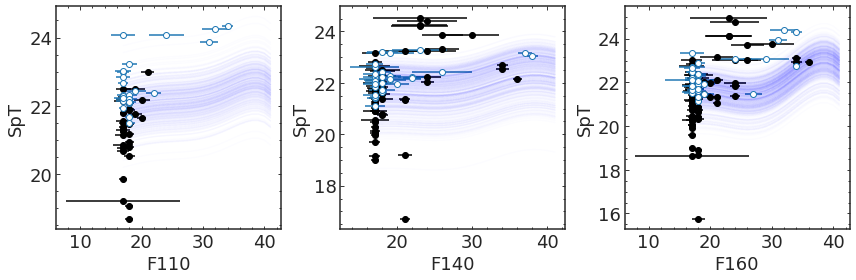

In [20]:
fig, ax=plt.subplots(figsize=(12, 4), ncols=3)

ax[0].errorbar(tab.spt[flags], tab.F110W[flags], xerr=tab.spt_er[flags], yerr=tab.F110W_er[flags], fmt='o', c='k')
ax[0].errorbar(tab.spt[~flags], tab.F110W[~flags], xerr=tab.spt_er[~flags], yerr=tab.F110W_er[~flags], \
                mfc='white', fmt='o')

ax[1].errorbar(tab.spt[flags], tab.F140W[flags], xerr=tab.spt_er[flags], yerr=tab.F140W_er[flags], fmt='o', c='k')
ax[1].errorbar(tab.spt[~flags], tab.F140W[~flags], xerr=tab.spt_er[~flags], yerr=tab.F140W_er[~flags], \
                mfc='white', fmt='o')


ax[-1].errorbar(tab.spt[flags], tab.F160W[flags], xerr=tab.spt_er[flags], yerr=tab.F160W_er[flags], fmt='o', c='k')
ax[-1].errorbar(tab.spt[~flags], tab.F160W[~flags], xerr=tab.spt_er[~flags], yerr=tab.F160W_er[~flags], \
                mfc='white', fmt='o')

for p in pnts:
    ax[0].plot(spgrid, p.mag_limits['F110']+(corr_pols['F110'+'W'][0])(spgrid), alpha=0.01, c='b')
    ax[1].plot(spgrid, p.mag_limits['F140']+(corr_pols['F140'+'W'][0])(spgrid), alpha=0.01, c='b')
    ax[-1].plot(spgrid, p.mag_limits['F160']+(corr_pols['F160'+'W'][0])(spgrid), alpha=0.01, c='b')

ax[0].set_xlabel('F110')
ax[1].set_xlabel('F140')
ax[-1].set_xlabel('F160')
ax[0].set_ylabel('SpT')
ax[1].set_ylabel('SpT')
ax[-1].set_ylabel('SpT')

for a in ax:
    a.minorticks_on()
plt.tight_layout()

In [21]:
tab.columns

Index(['H_2O-1/J-Cont', 'H_2O-1/J-Cont_er', 'H_2O-2/H_2O-1',
       'H_2O-2/H_2O-1_er', 'H-cont/H_2O-1', 'H-cont/H_2O-1_er', 'CH_4/H_2O-1',
       'CH_4/H_2O-1_er', 'H_2O-2/J-Cont', 'H_2O-2/J-Cont_er', 'H-cont/J-Cont',
       'H-cont/J-Cont_er', 'CH_4/J-Cont', 'CH_4/J-Cont_er', 'H-cont/H_2O-2',
       'H-cont/H_2O-2_er', 'CH_4/H_2O-2', 'CH_4/H_2O-2_er', 'CH_4/H-Cont',
       'CH_4/H-Cont_er', 'H_2O-1+H_2O-2/J-Cont', 'H_2O-1+H_2O-2/J-Cont_er',
       'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+H_2O-2/H-Cont_er', 'H_2O-1+CH_4/J-Cont',
       'H_2O-1+CH_4/J-Cont_er', 'H_2O-2+CH_4/J-Cont', 'H_2O-2+CH_4/J-Cont_er',
       'H_2O-1+CH_4/H-Cont', 'H_2O-1+CH_4/H-Cont_er', 'H_2O-2+CH_4/H-Cont',
       'H_2O-2+CH_4/H-Cont_er', 'spectra', 'grism_id', 'spt', 'spt_er',
       'distance', 'distance_er', 'coord', 'designation', 'F110W', 'F110W_er',
       'F160W', 'F160W_er', 'F140W', 'F140W_er', 'snr1', 'snr2', 'snr3',
       'snr4', 'x', 'line_chi', 'spex_chi', 'f_test', 'selected_by_rf',
       'selected_by_nn

In [22]:
def compute_average_height_of_population():
    pass
    
    return 

In [23]:
#wisps.POLYNOMIALS

In [24]:
#.MAG_LIMITS

In [25]:
subtab=(tab[tab.spt.between(30, 35)]).reset_index(drop=True)

In [26]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print( subtab[['F140W', 'F160W', 'lim_F140', 'lim_F160', 'detected_F140', 'detected_F160', 'grism_id',
#                  'spt']])

In [27]:
#NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl')
NUMBERS=get_all_numbers()

100%|███████████████████████████████████████████| 72/72 [04:04<00:00,  3.40s/it]


In [28]:
NUMBERS.keys()

dict_keys(['burrows1997', 'burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'])

In [29]:
#plt.hist(np.log10(NUMBERS['baraffe2003'][0][:,1]))

In [30]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=(np.nansum(volumes, axis=0))*4.1*(u.arcmin**2).to(u.radian**2)

In [31]:
MODEL_NAMES, MODEL_SHORT_NAMES

(['burrows1997',
  'burrows2001',
  'baraffe2003',
  'saumon2008',
  'marley2019',
  'phillips2020'],
 ['B97', 'B01', 'B03', 'SM08', 'M18', 'P20'])

In [32]:

def plot(NUMBERS, VOLUMES, filename='/oberved_numbers.pdf'):
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)

    fig, ax=plt.subplots(figsize=(14, 8), ncols=3, nrows=2, sharey=True, sharex=False)
    
    for model, name, a in zip(MODEL_NAMES, MODEL_SHORT_NAMES, np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2_labels, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          color= cmap(cnorm(h)), 
                   linewidth=3, drawstyle="steps-mid")
            #a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
             #              bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
             #              color= cmap(cnorm(h/100)),  step="mid")
        
        a.set_yscale('log')
        a.errorbar(spgrid2_labels,y2, yerr=dy2,fmt='o', color='#111111')
        a.errorbar(spgrid2_labels,yall, yerr=dyall,color='#B10DC9', mfc='white', fmt='o')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
        a.set_title('Model= {}'.format(name), fontsize=18)
            

    ax[1][-2].errorbar(spgrid2_labels,y2, yerr=dy2,fmt='o', label='Mag Limited', color='#111111')
    ax[1][-2].errorbar(spgrid2_labels,yall, yerr=dyall,color='#B10DC9', fmt='o', mfc='white', label='All Observations')
    
    #ax[-1][-2].legend(fontsize=14,  bbox_to_anchor=(1.05, 1), loc='upper left')
    #fig.delaxes(np.concatenate(ax)[-1])
    ax[1][-2].legend( fontsize=14, loc='upper right')
    
    cax = fig.add_axes([1.01, 0.25, .015, 0.5])
    mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel(r'Scaleheight (H, pc)', fontsize=18)
    #cbar.ax.set_yticks([1, 3, 5, 10])
    #np.concatenate(ax)[-2].legend(loc='center left', bbox_to_anchor=(1, 1.5), fontsize=14)
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


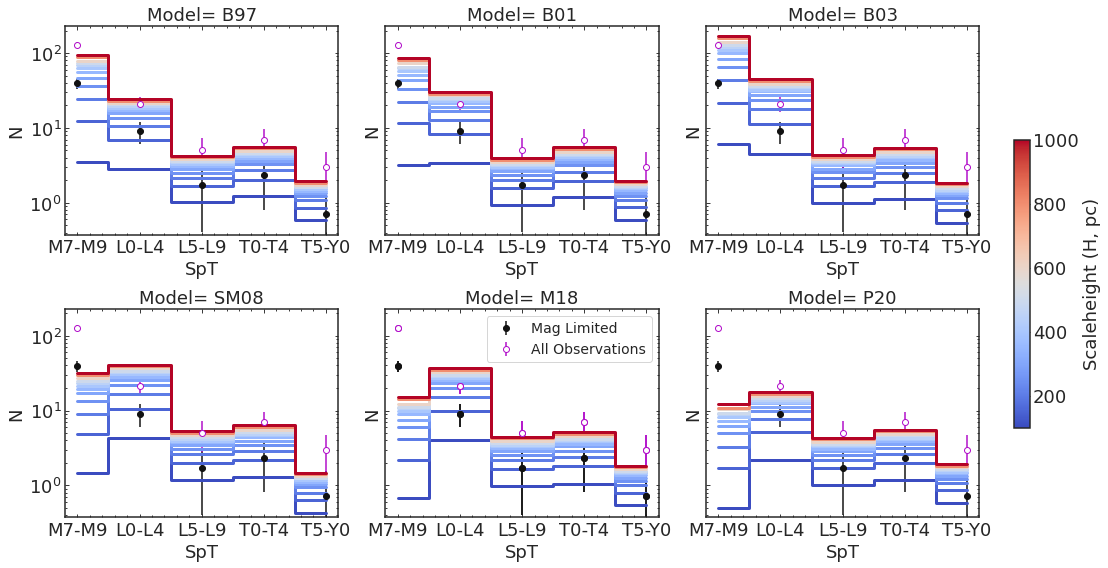

In [33]:
 plot(NUMBERS, VOLUMES, filename='/obs_numbers_plus_binaries_12percent_thick_disk_updated.pdf')

In [34]:
#plot_one(NUMBERS, VOLUMES, filename='/oberved_numbers_one_panel.pdf')

In [35]:
#bbjnkl

In [36]:
#save into pickle file
#NUMBERS
#counts_numbers={'volumes': VOLUMES, 'densities': NUMBERS, 'scaleheights': wispsim.HS, 'nobs': nobs}
#import pickle
#with open(wisps.OUTPUT_FILES+'/expected_numbers_wisps_plus_binaries.pkl', 'wb') as file:
#    pickle.dump(counts_numbers,file)

In [37]:
nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK

In [38]:
y2, THICK

(array([39.33655144,  9.09516131,  1.71045316,  2.3325168 ,  0.71228077]),
 array([36.66344856,  6.90483869,  0.28954684,  0.6674832 ,  0.28771923]))

In [39]:
def asymetric_errors(vals):
    if len(vals)<1:
        return [np.nan, np.nan]
    else:
        med= np.nanmedian(vals)
        up= np.nanpercentile(vals, 86)
        dn= np.nanpercentile(vals, 14)
        return np.array([med-dn, up-med])

In [40]:
np.nanpercentile(wispsim.HS, 10)

155.0

In [41]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)-THICK
y4=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=True)#-THICK
y5= np.nansum(y4)
print ('all ----- {}'.format(y3))
print ('used ----- {}'.format(y2))
print ('MLT ----{}'.format(y4))
print ('All ----{}'.format(y5))


all ----- [91.33655144 14.09516131  4.71045316  6.3325168   2.71228077]
used ----- [39.33655144  9.09516131  1.71045316  2.3325168   0.71228077]
MLT ----[76, 18, 4]
All ----98


In [42]:
np.shape(NUMBERS['marley2019'][5])

(25, 2)

In [43]:
np.shape(wispsim.SPGRID)

(25,)

In [44]:
wispsim.HS

[100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 800, 1000]

In [45]:
NUMBERS['marley2019'][5][-3][0]*VOLUMES[:,-3][5]

0.003996358071361398

In [46]:
#np.shape()

In [47]:
#hjk

In [48]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={} #predictions for all
numbers_fit_lt={} #predictions for M, L, T
#numbers_fit_total={} #predictions for total number counts
for model in MODEL_NAMES:
        model_number_lt={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            binned_lt= np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=True))
            #binned_unc=np.array(bin_by_spt_bin(wispsim.SPGRID,nuncs, ltonly=False))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            #binned_total=np.append(binned, binned_lt)
            #binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned})
            model_number_lt.update({h: binned_lt})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})
        numbers_fit_lt.update({model:  model_number_lt})

In [49]:
#chisq_dicts=pd.DataFrame.from_records(best_fit)
pred_number_dicts=pd.DataFrame.from_records(numbers_fit)
pred_number_lt_dicts=pd.DataFrame.from_records(numbers_fit_lt)

In [50]:
from scipy.interpolate import interp1d

In [51]:
import scipy.stats as stats

In [52]:


def get_poisson_predictions(spt_grid, obstns, predns):
    res={}
    for c in  predns.columns:
        min_vals={}
        dist={}
        #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
        for idx,s  in enumerate(spt_grid):
            #compare between subtypes
            #predicted
            predvals=(np.vstack(predns[c].values))[:,idx]
            #observed
            nreal=  obstns[idx]
            #make an interpolation function
            interpf = interp1d(predvals, wispsim.HS)
            #using a 2nd degree polynomial 
            #interpf = np.poly1d(np.polyfit(predvals, wispsim.HS, 3))

            #draw a bunch of random values based on a poisson distribution
            #npoisson=np.random.poisson(nreal, 100000).astype(float)
            #print (nreal)
            npoisson=stats.gamma.rvs(nreal, size =int(1e5))
            #stay within the range of possible values to avoid interpolation error
            #i.e take this as a prior
            #dflag=npoisson>=vals.min()
            #uflag= npoisson <=vals.max()
            #npoisson[dflag]= vals.min()
            #npoisson[uflag]= vals.max()
            #allow extraploayion
            npoisson=npoisson[np.logical_and(npoisson>=predvals.min(), npoisson <=predvals.max())]
            #predict scale heights
            predhs=interpf(npoisson)
            #use a weighted mean and std 
            #mean, unc= (np.nanmean(predhs), np.nanstd(predhs))

            #print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
            dist.update({s:predhs})
        #min_chi_ssqrs.update({c:min_vals})
        res.update({c: dist})
    return  res

In [53]:
def scaleheight_to_vertical_disp(hs):
    shape=435 #shape parameter
    sigma_68=1.
    return np.sqrt((np.array(hs))/shape)*20

def compute_age_with_z(sigmas, z):
    ag_bov= popsims.avr_yu(sigmas[abs(z) >270], verbose=True, nsample=2, height='above')[0]
    ag_bel=popsims.avr_yu(sigmas[abs(z) <=270], verbose=True, nsample=2, height='below')[0]
    return np.concatenate([ag_bov, ag_bel]).flatten()

def asssymetric_med_std(x):
    return np.round(np.nanmedian(x), 2), np.round(asymetric_errors(x), 2)

In [54]:
from popsims import galaxy

In [55]:
def resample_median_ages(ages, N, nsample=int(1e4)):
    """
    Sample N stars over nsampels and recompute the median
    
    """
    if len(ages) < 1:
        return []
    else:
        return np.array([np.nanmedian(np.random.choice(ages, int(N))) for x in range(int(nsample))])

In [56]:
scale_height_dist=get_poisson_predictions(spgrid2, y2,pred_number_dicts)
scale_height_dist_df=pd.DataFrame(scale_height_dist)

In [57]:
scale_height_dist_df['saumon2008']['M7-L0']=[]
from popsims import galaxy;

In [58]:
#obs

In [59]:
SPGRID2_DICT= dict(zip(spgrid2, y2))
SPGRID2_DICT

{'M7-L0': 39.33655143537195,
 'L0-L5': 9.095161309171269,
 'L5-T0': 1.7104531622152928,
 'T0-T5': 2.3325168032592583,
 'T5-Y0': 0.7122807650883125}

In [60]:
#marley, phillips and saumon models don't cover the parameter range
for c in ['marley2019', 'phillips2020', 'saumon2008']:
    scale_height_dist_df.loc['M7-L0', c]= []

In [61]:
scale_height_dist_df

,baraffe2003,burrows1997,burrows2001,marley2019,phillips2020,saumon2008
M7-L0,"[191.8666497224538, 207.5828476878116, 177.501...","[244.67976306606894, 291.3830678056654, 258.38...","[248.40628632055984, 272.44850155169854, 328.3...",[],[],[]
L0-L5,"[124.45747045246458, 108.91509779487316, 127.3...","[146.9059146450055, 185.76749818297426, 199.49...","[109.7292273243881, 140.37351411780386, 301.87...","[141.49535164835507, 184.95512524225208, 121.7...","[247.04020630946528, 208.54526600863394, 147.5...","[107.36517117801704, 139.4887973678163, 163.09..."
L5-T0,"[341.55221818302437, 276.2182168954929, 145.87...","[113.39507437025068, 378.65131920774724, 228.2...","[217.57289330765602, 490.5132511721306, 132.66...","[523.5931885650384, 175.86876916816175, 137.42...","[123.47460269320831, 289.0650478800352, 261.87...","[160.6381166400906, 124.9705353982387, 154.920..."
T0-T5,"[318.9384725744388, 118.03264534564346, 192.49...","[302.14908275316975, 151.30971458880268, 677.2...","[100.98322465426396, 131.29045314234915, 245.3...","[195.75954319224905, 914.0750982863093, 347.11...","[248.59924129954499, 119.07917253006377, 268.2...","[285.5252373372885, 117.35381472253339, 102.99..."
T5-Y0,"[284.8216141595255, 120.45010663761565, 136.15...","[898.6398425199604, 102.38623331406517, 160.09...","[412.2455626222262, 669.3583382837476, 137.372...","[131.45359425377987, 324.9239944750872, 128.67...","[175.4079804034424, 244.8726376708368, 123.751...","[110.78881633009209, 201.88811808801324, 939.0..."


In [62]:
#scale_height_dist=get_poisson_predictions(spgrid2, y2,pred_number_dicts)
#scale_height_dist_df=pd.DataFrame(scale_height_dist)
vel_df=scale_height_dist_df.applymap(scaleheight_to_vertical_disp)
age_distdf_yu=vel_df.applymap(lambda x:  galaxy.avr_yu(x, verbose=False, nsample=2, height='median')[0])
age_distdf_just=vel_df.applymap(lambda x:  galaxy.avr_just(x, verbose=False))
age_distdf_sand=vel_df.applymap(lambda x:  galaxy.avr_sanders(x, verbose=False))
age_distdf_aumer=vel_df.applymap(lambda x: galaxy.avr_aumer(x, verbose=False))
age_distdf_sharma=vel_df.applymap(lambda x: galaxy.avr_sharma(x, verbose=False)[0])

scalh_tables=scale_height_dist_df.applymap( asssymetric_med_std)
vel_tables=vel_df.applymap(asssymetric_med_std)
#age_tables_yu=age_distdf_yu.applymap( asssymetric_med_std)
age_tables_just=age_distdf_just.applymap( asssymetric_med_std)
#age_tables_sand=age_distdf_sand.applymap( asssymetric_med_std)
age_tables_aumer=age_distdf_aumer.applymap( asssymetric_med_std)
age_tables_sharma=age_distdf_sharma.applymap( asssymetric_med_std)

In [63]:
median_diff=pd.DataFrame(columns= age_tables_sharma.columns, index=age_tables_sharma.index)

In [64]:
for c in age_tables_sharma.columns:
    for idx in age_tables_sharma.index:
        diff0=(np.diff([age_tables_sharma.loc[idx, c][0], \
                        age_tables_aumer.loc[idx, c][0],\
                        age_tables_just.loc[idx, c][0]])).sum()
        median_diff.loc[idx, c]=diff0

In [65]:
median_diff.max().max()

-1.0100000000000002

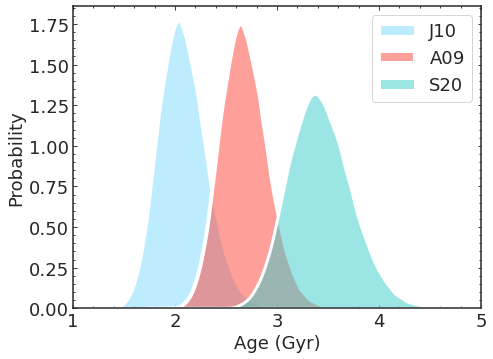

In [139]:
fig, ax=plt.subplots(figsize=(8*0.85, 6*0.85))
#_= plt.hist(age_distdf_sharma.loc['M7-L0', 'baraffe2003'], \
#            log=True, bins=32, histtype='step')

#_= plt.hist(age_distdf_yu.loc['M7-L0', 'baraffe2003'], \
#            log=True, bins=32, histtype='step')

_= sns.kdeplot(age_distdf_just.loc['M7-L0', 'baraffe2003'], lw=3, linestyle='-', \
               color='#7FDBFF', label='J10',\
                   ax=ax, common_grid=True, multiple="stack", alpha=0.5)

_= sns.kdeplot(age_distdf_aumer.loc['M7-L0', 'baraffe2003'], lw=4, linestyle='-', color='#FF4136', \
    label='A09', ax=ax, common_grid=True,multiple="stack", alpha=0.5)

_= sns.kdeplot(age_distdf_sharma.loc['M7-L0', 'baraffe2003'], lw=3, linestyle='-', \
               color='#39CCCC', label='S20',\
                   ax=ax, common_grid=True, multiple="stack", alpha=0.5)

ax.set(xlim=[1, 5], xlabel='Age (Gyr)', ylabel='Probability')
ax.legend()
ax.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/avr_comparisons.pdf', bbox_inches='tight')

In [67]:
import matplotlib as mpl
mpl.rcParams['figure.titlesize'] = 'large'

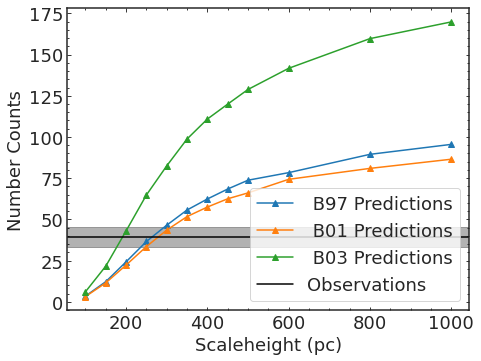

In [68]:
idx=0
fig, ax=plt.subplots(figsize=(8*0.85, 6*0.85))
for m, ac in zip(['burrows1997', 'burrows2001', 'baraffe2003',], ['B97', 'B01', 'B03']):
    predvals=(np.vstack(np.vstack(pred_number_dicts[m].values)))[:,idx]
    #observed

    #make an interpolation function
    #interpf = np.poly1d(np.polyfit(predvals, wispsim.HS, 3))
    interpf =interp1d(predvals, wispsim.HS)

    rvs=stats.gamma.rvs(y2[idx], size =int(1e5))
    #rvs=rvs[np.logical_and(rvs>=predvals.min(), rvs <=predvals.max())]

    ax.plot(  wispsim.HS, predvals, marker='^', label=' {} Predictions'.format(ac))
    #ax[0].plot(  rvs, interpf(rvs), '.')
    
ax.axhline(y2[idx], color='k', label='Observations')
ax.axhspan(y2[idx]-np.sqrt(y2[idx]), y2[idx]+np.sqrt(y2[idx]), alpha=0.3, color='k')

ax.set(xlabel='Scaleheight (pc)', ylabel='Number Counts')


ax.minorticks_on()
ax.legend()
#fig.delaxes(ax0[1])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/model_interpolation_ncounts.pdf', bbox_inches='tight')

In [69]:
def reformat(val):
    return str(val[0])+'$ _{-'+str(val[1][0])+'} ^{+'+str(val[1][1])+'}$'

In [70]:
scalh_tables

,baraffe2003,burrows1997,burrows2001,marley2019,phillips2020,saumon2008
M7-L0,"(190.5, [14.9, 16.56])","(262.15, [28.25, 35.98])","(277.3, [31.45, 38.4])","(nan, [nan, nan])","(nan, [nan, nan])","(nan, [nan, nan])"
L0-L5,"(132.53, [19.57, 26.15])","(175.34, [35.98, 52.78])","(156.01, [29.07, 39.32])","(141.4, [23.26, 31.86])","(221.66, [56.31, 118.96])","(136.77, [21.5, 28.33])"
L5-T0,"(174.96, [58.49, 162.88])","(174.0, [57.83, 172.61])","(175.42, [58.86, 199.04])","(174.92, [58.54, 180.6])","(172.63, [56.39, 187.78])","(160.06, [46.53, 136.26])"
T0-T5,"(185.54, [64.55, 179.7])","(177.6, [58.97, 164.39])","(181.27, [61.76, 186.47])","(191.47, [69.29, 185.18])","(180.62, [61.32, 168.13])","(172.93, [55.49, 150.06])"
T5-Y0,"(187.24, [68.89, 269.8])","(181.14, [64.06, 233.45])","(182.69, [65.68, 228.84])","(187.86, [69.12, 228.27])","(182.54, [65.24, 233.86])","(196.09, [75.59, 231.39])"


In [71]:
#some models don't conver the

In [72]:
#scalh_tables[g].applymap(reformat)

In [73]:
#vel_tables[MODEL_NAMES].applymap(reformat)

In [74]:
#age_tables_just[MODEL_NAMES].applymap(reformat)

In [75]:
#upper and lo limits on ages 
#up_lims_table=pd.DataFrame(columns= age_tables.columns,
#                           index=age_tables.index).fillna(0)
#up_lims_table.saumon2008['T0-T5']=1
#up_lims_table.saumon2008['T0-T5']=1

#lo limts
#lo_lims_table=pd.DataFrame(columns= age_tables.columns,
#                           index=age_tables.index).fillna(0)
#lo_lims_table.baraffe2003['T5-Y0']=1
#lo_lims_table.baraffe2003['L5-T0']=1
#lo_lims_table.phillips2020['T5-Y0']=1
#lo_lims_table.saumon2008['T5-Y0']=1
#lo_lims_table.marley2019['T5-Y0']=1


In [76]:
def get_simpler_class(x):
    if x.startswith('M'):
        return 'Late M'
    if x.startswith('L'):
        return 'L'
    if x.startswith('T'):
        return 'T'

In [77]:
def get_age_dictionaries(model):
    dfs=[]
    for hidx in wispsim.HS:
        #hidx is a scale height, model is evolutionary model
        df0=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_binaries_updatedrelations.h5',\
                          key=str(model)+str(hidx)+str('spt_abs_mag'))
        cutdf=(df0[~df0.is_cut]).rename(columns={'temperature': 'teff', \
                                              'slprob': 'sl'})
        
        
        dfs.append(cutdf)
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.subtype.apply(get_simpler_class)
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]

    return final_df[['age', 'subtype', 'spt', 'spectclass']]

In [78]:
#plot age with scale heights
age_dictionaries={}
for model in tqdm(MODEL_NAMES):
       age_dictionaries[model]= get_age_dictionaries(model)
    

  0%|                                                     | 0/6 [00:00<?, ?it/s]

1153459


 17%|███████▌                                     | 1/6 [00:37<03:08, 37.65s/it]

1197436


 33%|███████████████                              | 2/6 [01:16<02:34, 38.60s/it]

1549568


 50%|██████████████████████▌                      | 3/6 [01:57<01:59, 39.72s/it]

1254762


 67%|██████████████████████████████               | 4/6 [02:36<01:18, 39.16s/it]

1085536


 83%|█████████████████████████████████████▌       | 5/6 [03:13<00:38, 38.45s/it]

955825


100%|█████████████████████████████████████████████| 6/6 [08:39<00:00, 86.55s/it]


In [79]:
#a.errorbar(  agfn.age, agfn.subtype, xerr=np.vstack(agfn.unc).T,  fmt='o',xlolims=lolims, ms=20, lw=7, 
#               capsize=7, 
#               mfc='#0074D9', mec='#111111', ecolor='#111111', xuplims=uplims)
#age_dictionaries[model].columns

In [80]:

#plot age with scale heights
age_dictionaries_median={}
for model in MODEL_NAMES:
    df=[]
    for g in age_dictionaries[model].replace('T5-T9', 'T5-Y0').groupby('subtype'):
        ages=g[1].age.values
        n= SPGRID2_DICT[g[0]]
        df0=pd.DataFrame()
        rages= resample_median_ages(ages, np.round(n), nsample=int(1e4))
        df0['age']= rages
        df0['subtype']=g[0]
        df.append(df0)
    age_dictionaries_median[model]=pd.concat(df)

In [81]:
def plot_one_age(a):
    model='baraffe2003'
    ds=[]
    dfn=age_dictionaries_median[model].replace('T5-T9', 'T5-Y0')
    for k in age_tables_just[model].keys():
        if len(scale_height_dist[model][k]) <1:
            pass
        else:
            #empirical
            #ds0.append(age_tables_just[model][k])
            #from simulations
            ds.append(dfn.age[dfn.subtype==k].values)
    #some reformatting
    positions=[0, 1, 2, 3, 4]
    lolims=[0, 0, 0, 0, 0]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=100, positions=positions,
               showmeans=True, showextrema=False, showmedians=False, vert =False)
    #for b in v1['bodies']: 
    #      b.set_color('#0074D9')
        #get the center
    xerr0=np.vstack((age_tables_just[model].apply(lambda x: x[1]).values)).T
    #xerr1=np.vstack((age_tables_sand[model].apply(lambda x: x[1]).values)).T
    xerr2=np.vstack((age_tables_aumer[model].apply(lambda x: x[1]).values)).T
    
    #set size of arrows
    xerr0.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    #xerr1.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr2.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    
    #a.errorbar(age_tables_just[model].apply(lambda x: x[0]).values, \
    #           np.array([0, 1, 2, 3, 4])-0.5,\
    #           xerr=xerr0,  fmt='o', label='J10', \
    #          ms=10, lw=5,  capsize=5,
    #           xlolims=lolims)
    
    #a.errorbar(age_tables_yu[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.2,\
    #           xerr=np.vstack((age_tables_yu[model].apply(lambda x: x[1]).values)).T,  fmt='o', label='Y18',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5)
    
    #a.errorbar(age_tables_sand[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.0,\
    #           xerr=xerr1,  fmt='o', label='SB15',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5,
    #            xlolims=lolims)
    
    a.errorbar(age_tables_aumer[model].apply(lambda x: x[0]).values,  \
               np.array([0, 1, 2, 3, 4])+0.1,\
              xerr=xerr2,  fmt='o', label='AB09',
               ms=10, lw=5, capsize=5,
                xlolims=lolims)
    
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel('Age (Gyr)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    a.set_xlim([-1, 10])
    a.set_title('Model= B03', fontsize=18)
    a.legend(fontsize=12, loc='lower left')
   
    plt.tight_layout()
    

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


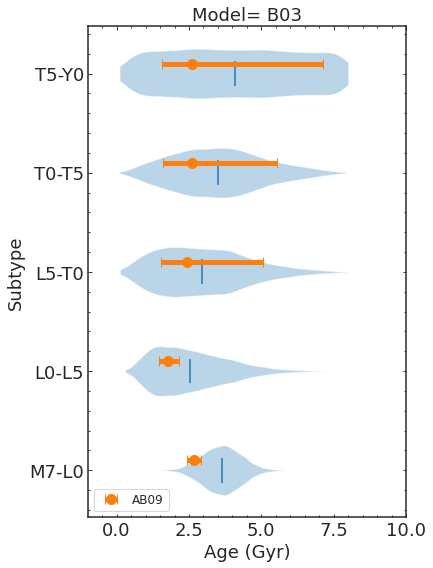

In [82]:
##plt.style.use('dark_background')
fig, ax=plt.subplots(figsize=(6, 8))
plot_one_age(ax)
plt.savefig(wisps.OUTPUT_FIGURES+'/one_age_comparison.pdf', 
            bbox_inches='tight',   facecolor='black', transparent=False)
    

In [83]:
import scipy.stats as stats

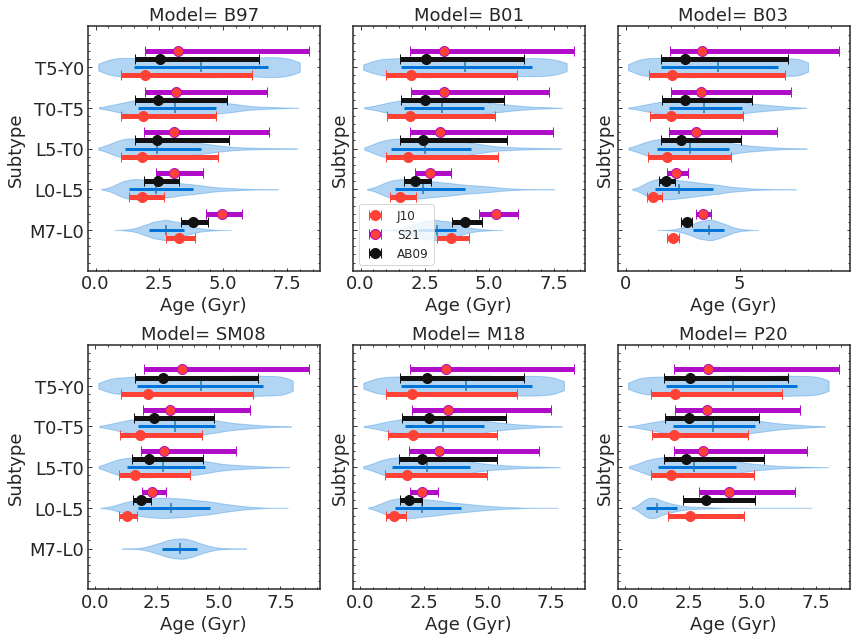

In [84]:
fig, ax=plt.subplots(figsize=(12, 9), ncols=3, nrows=2, sharex=False, sharey=True)
for model, name, a in zip( MODEL_NAMES, MODEL_SHORT_NAMES, np.concatenate(ax)):

    ds=[]
    qs=[]
    
    dfn=age_dictionaries_median[model].replace('T5-T9', 'T5-Y0')
    for k in age_tables_just[model].keys():
        if len(scale_height_dist[model][k]) <1:
            pass
            qs.append([np.nan, np.nan])
        else:
            #empirical
            #ds0.append(age_tables_just[model][k])
            #from simulations
            ds.append(dfn.age[dfn.subtype==k].values)
            qs.append(np.percentile(dfn.age[dfn.subtype==k].values, [16, 84]))
    #some reformatting
    qs=np.vstack(qs)
    a.hlines([0, 1, 2, 3, 4], qs[:,0], qs[:,1], color='#0074D9', linestyle='-', lw=3)
    positions=[0, 1, 2, 3, 4]
    lolims=[0, 0, 0, 0, 0]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=100, positions=positions,
               showmeans=False, showextrema=False, showmedians=True, vert =False)
    for b in v1['bodies']: 
          b.set_color('#0074D9')
        #get the center
    xerr0=np.vstack((age_tables_just[model].apply(lambda x: x[1]).values)).T
    xerr1=np.vstack((age_tables_sharma[model].apply(lambda x: x[1]).values)).T
    xerr2=np.vstack((age_tables_aumer[model].apply(lambda x: x[1]).values)).T
    
    #set size of arrows
    xerr0.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr1.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr2.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    
    a.errorbar(age_tables_just[model].apply(lambda x: x[0]).values, np.array([0, 1, 2, 3, 4])-0.2,\
               xerr=xerr0,  fmt='o', label='J10', \
              ms=10, lw=5,  mfc='#FF4136', mec='#FF4136', ecolor='#FF4136', capsize=5,
               xlolims=lolims)
    
    a.errorbar(age_tables_sharma[model].apply(lambda x: x[0]).values, np.array([0, 1, 2, 3, 4])+0.4,\
           xerr=    xerr1,  fmt='o', label='S21', \
          ms=10, lw=5,  mfc='#FF4136', mec='#B10DC9', ecolor='#B10DC9', capsize=5,
           xlolims=lolims)
    
    #a.errorbar(age_tables_yu[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.2,\
    #           xerr=np.vstack((age_tables_yu[model].apply(lambda x: x[1]).values)).T,  fmt='o', label='Y18',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5)
    
    #a.errorbar(age_tables_sand[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.0,\
    #           xerr=xerr1,  fmt='o', label='SB15',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5,
    #            xlolims=lolims)
    
    a.errorbar(age_tables_aumer[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.2,\
               xerr=xerr2,  fmt='o', label='AB09',
               ms=10, lw=5,  mfc='#111111', mec='#111111', ecolor='#111111', capsize=5,
                xlolims=lolims)
    
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel('Age (Gyr)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    a.set_ylim([-1, 5])
    a.set_title('Model= {}'.format(name), fontsize=18)
    
ax[0][-2].legend(fontsize=12, loc='lower left')

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison_plus_binaries_12percent_thick_disk_updated.jpeg', bbox_inches='tight',  \
            facecolor='white', transparent=True)

In [85]:
combined_age_dists_from_avrs=pd.DataFrame(columns= age_distdf_aumer.columns, index=  age_distdf_aumer.index)

In [86]:
#for c in combined_age_dists_from_avrs.columns:
#    for idx in combined_age_dists_from_avrs.index:
#        combined_age_dists_from_avrs.loc[idx, c]= np.concatenate([age_distdf_aumer.loc[idx, c], \
#                                                              #age_distdf_sharma.loc[idx, c],
#                                                              age_distdf_just.loc[idx, c]])

In [87]:
#use AUMER for now
combined_age_dists_from_avrs=age_distdf_aumer

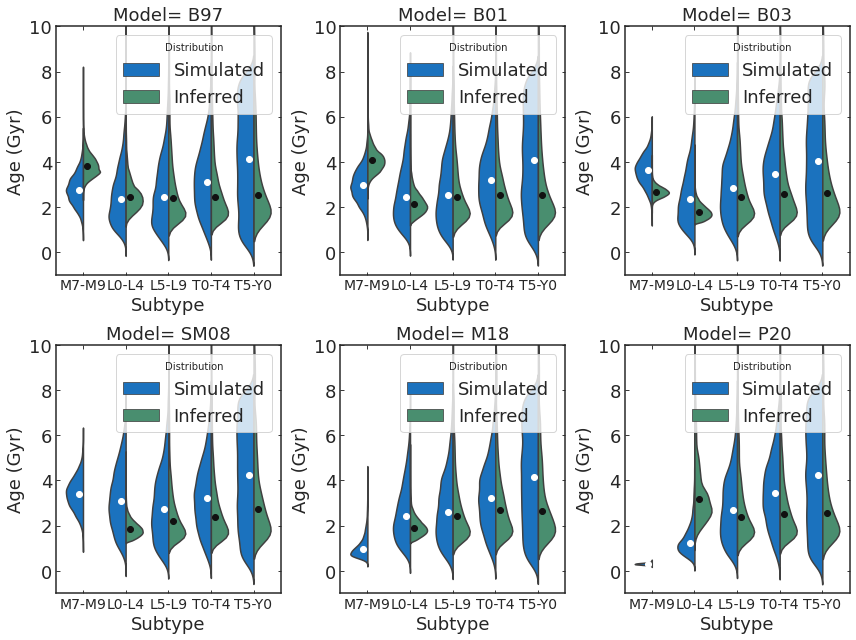

In [137]:

fig, ax=plt.subplots(figsize=(12, 9), ncols=3, nrows=2, sharex=False, sharey=False)

for model, name, a in zip( MODEL_NAMES, MODEL_SHORT_NAMES, np.concatenate(ax)):

    master_list=[]
    median_ages=[]
    for idx in range(len(combined_age_dists_from_avrs.index)):

        subtype=combined_age_dists_from_avrs.index[idx]
        dfn=age_dictionaries_median[model].replace('T5-T9', 'T5-Y0')

        age_simulated= dfn.age[dfn.subtype==subtype].values
        
        sim_df=pd.DataFrame()
        sim_df['Age (Gyr)']=age_simulated
        sim_df['Subtype']=idx
        sim_df['Distribution']= 'Simulated'

        real_df=pd.DataFrame()
        real_df['Age (Gyr)']= combined_age_dists_from_avrs.loc[subtype, model]
        real_df['Distribution']= 'Inferred'
        real_df['Subtype']=idx
        
        #compute percentiles
        #left_per= [np.percentile(real_df['Age (Gyr)'], 16), \
        #           np.percentile(real_df['Age (Gyr)'], 50),\
        #           np.percentile(real_df['Age (Gyr)'], 84)]
        median_left= np.nanmedian(age_simulated)
        median_right= np.nanmedian( real_df['Age (Gyr)'].values)
     

        master_list.append(pd.concat([real_df, sim_df]))
        median_ages.append([median_left,    median_right])

        #visualize this differently 
    master_df=pd.concat(master_list)
    _ = sns.violinplot(x="Subtype", y='Age (Gyr)', hue="Distribution",
                       inner=None,
                        data=master_df, palette = {'Simulated':'#0074D9', 'Inferred':'#3D9970'},
                        scale='width', split=True, hue_order=['Simulated', 'Inferred'], height=4, aspect=.7, ax=a, trim=True)
    del master_list
    del master_df
    
    a.scatter(np.array([0, 1, 2, 3, 4])-0.1, np.vstack(median_ages)[:,0], color='white')
    a.scatter(np.array([0, 1, 2, 3, 4])+0.1, np.vstack(median_ages)[:,1], color='#111111')
    
    a.set_xticks([0, 1, 2, 3, 4])
    a.set_xticklabels(spgrid2_labels, fontsize=14)
    plt.setp(a.get_yticklabels(), visible=True)
    
    a.set_ylim([-1, 10])
    a.set_title('Model= {}'.format(name), fontsize=18)

plt.tight_layout()

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison_plus_binaries_12percent_thick_disk_updated_alt.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)

In [89]:
from matplotlib.collections import LineCollection

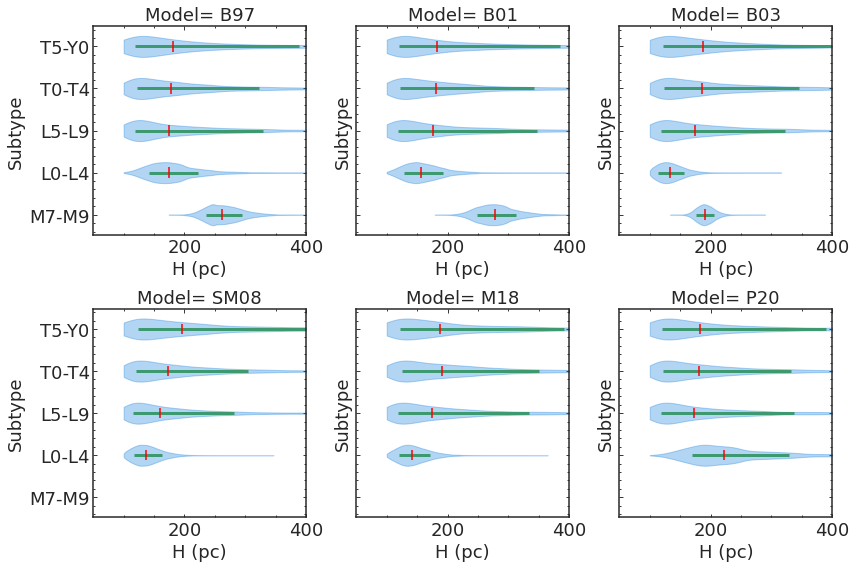

In [90]:
fig, ax=plt.subplots(figsize=(12, 8), ncols=3, nrows=2, sharex=False, sharey=True)

for model, name, a in zip( MODEL_NAMES, MODEL_SHORT_NAMES, np.concatenate(ax)):
    ds=[]
    qs=[]
    for k in scale_height_dist_df[model].index:
        if len(scale_height_dist_df[model][k]) <10:
            pass
            qs.append([np.nan, np.nan])
        else:
            ds.append(scale_height_dist_df[model][k])
            qs.append(np.percentile(scale_height_dist_df[model][k], [16, 84]))
            
    qs=np.vstack(qs)
    a.hlines([0, 1, 2, 3, 4], qs[:,0], qs[:,1], color='#3D9970', linestyle='-', lw=3)

    positions=[0, 1, 2, 3, 4]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=3000, positions=positions,
               showmeans=False, showmedians=True,  \
                      showextrema=False, vert =False)
    for b in v1['bodies']: 
          b.set_color('#0074D9')
    v1['cmedians'].set_color('r')
        #get the center
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2_labels)
    a.set_xlabel('H (pc)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    a.set(xlim=[50, 400])
    a.set_title('Model= {}'.format(name), fontsize=18)


plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/scaleheight_comparison.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)


In [91]:
ls=np.concatenate([np.concatenate(scale_height_dist_df.loc['L0-L5'].values).flatten(),\
                  np.concatenate(scale_height_dist_df.loc['L5-T0'].values).flatten()])

ts=np.concatenate([np.concatenate(scale_height_dist_df.loc['T0-T5'].values).flatten(),\
                  np.concatenate(scale_height_dist_df.loc['T5-Y0'].values).flatten()])

In [92]:
print ('T ', asssymetric_med_std(ts))

T  (182.92, array([ 63.8 , 191.59]))


In [93]:
171+134

305

In [94]:
print ('L ', asssymetric_med_std(ls))

L  (156.95, array([37.29, 97.97]))


In [95]:
print ('M ',asssymetric_med_std(np.concatenate(scale_height_dist_df.loc['M7-L0'].values).flatten()))

M  (248.89, array([61.28, 47.9 ]))


In [96]:
#print ('T ',asssymetric_med_std(np.concatenate(scale_height_dist_df.loc['T-L0'].values).flatten()))

In [97]:
ignore_models_dict={'L0-L5': ['phillips2020'], 'M7-L0':[], 'L5-T0':[],\
                    'T0-T5':[], 'T5-Y0':[],  'T5-Y0':[]}

In [133]:
def get_median(df, subtype, rund=1):
    ignore_models=ignore_models_dict[subtype]
    all_models=MODEL_NAMES
    mds=[x for x in all_models if x not in ignore_models]
    vs=np.concatenate(df[mds].loc[subtype].values).flatten()
    val, unc=asssymetric_med_std(vs)
    res=''
    if np.isnan(val):
            res += r'\nodata&'
    else:
        if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
        else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
        res += st
    
    return res
def get_formatted_string(df, subtype, rund=1):
    dn=df.loc[subtype]
    res=''
    for md in MODEL_NAMES:
        val= dn[md][0]
        unc=dn[md][1]
        if np.isnan(val):
            res += r'\nodata &'
        else:
            if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
            else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
            res += st
    return res

def get_age_median_from_simulation(subtype, rund=1):
    res=''
    
    for model in MODEL_NAMES:
        dfn0=age_dictionaries_median[model].replace('T5-T9', 'T5-Y0')
        dfn=dfn0[dfn0.subtype==subtype]
        if len(scale_height_dist[model][subtype]) <1:
            res += r'\nodata &'
        else:
            val, unc= asssymetric_med_std(dfn['age'].values)
            if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
            else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
            res += st
    return res

def get_age_median_all_from_simulation(subtype, rund=1):
    ignore_models=ignore_models_dict[subtype]
    ds=[]
    res=''
    all_models=MODEL_NAMES
    mds=[x for x in all_models if x not in ignore_models]
    for model in mds:
        dfn0=age_dictionaries_median[model].replace('T5-T9', 'T5-Y0')
        ds.append(dfn0[dfn0.subtype==subtype].age.values)
    val, unc=asssymetric_med_std(np.concatenate(ds))
    st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
    res += st
    return res

def get_ks_stats(subtype, rund=1, compareto='aumer'):
    res=''
    for model in MODEL_NAMES:
        dfn=age_dictionaries_median[model].replace('T5-T9', 'T5-Y0')
        x=dfn[dfn.subtype ==subtype].age.values
        if compareto=='aumer': y=age_distdf_aumer[model][subtype]
        if compareto=='just': y=age_distdf_just[model][subtype]
        if len(y)<2:
            res +=r'\nodata &'
        else:
            val=stats.ks_2samp(x, y, mode='asymp', alternative='two-sided')[0]
            st= str(np.round(val, rund))+'&'
            res += st
    return res

In [131]:
def custom_overlap_probability(subtype, ranges=[0, 13], rund=3, compareto='aumer'):
    grid=np.linspace(ranges[-1], ranges[1], 100)
   
    res=''
    for model in MODEL_NAMES:
        dfn=age_dictionaries_median[model].replace('T5-T9', 'T5-Y0')
        x=dfn[dfn.subtype ==subtype].age.values
        if compareto=='aumer':y=age_distdf_aumer[model][subtype]
        if compareto=='just': y=age_distdf_just[model][subtype]
        if len(y)<2:
            res +='\nodata &'
        else:
            #Create overlapping probabilities
            kde_sim=stats.kde.gaussian_kde(x)
            kde_obs=stats.kde.gaussian_kde(y)

            num=np.trapz(kde_sim(grid)*kde_obs(grid), x=grid)
            den=np.trapz(kde_sim(grid), x=grid)*np.trapz(kde_obs(grid), x=grid)
            val=num/den
            st= str(np.round(val, rund))+'&'
            res += st
    
    return res
                                                
                            

In [100]:
grid=np.linspace(0, 13, 5000 )
x=np.random.normal(5, 1, 1000)
y=np.random.normal(5, 1, 1000)

In [101]:
kde_sim=stats.kde.gaussian_kde(x)
kde_obs=stats.kde.gaussian_kde(y)

num=np.trapz(kde_sim(grid)*kde_obs(grid), x=grid)
den=np.trapz(kde_sim(grid), x=grid)*np.trapz(kde_obs(grid), x=grid)

In [134]:
#print latex formatted 
for idx, subtype in enumerate(spgrid2):
    print (spgrid2_labels[idx] + r'&$H$ (pc) &' + get_formatted_string(scalh_tables, subtype, rund=0) \
           + get_median(scale_height_dist_df, subtype, rund=0) +  \
           str(int(np.round(y2)[idx]))+'&'+  str(np.round(THICK[idx], 1)) + r'\\ ')
    print (r' & $\sigma_w$ (km/s)  &' + get_formatted_string(vel_tables, subtype) \
           + get_median(vel_df, subtype) + '& '+ r'\\ ')
    
    print (r' & Age (Gyr) (A09)&' + get_formatted_string(age_tables_aumer, subtype)  \
           + get_median(age_distdf_aumer, subtype)+ '& '  + r'\\ ')
        
    #print (r' & Age (Gyr) (J10) &' + get_formatted_string(age_tables_just, subtype) \
    #       + get_median(age_distdf_just, subtype)+ '& ' + r'\\ ')
    #print (r' & Age (Gyr) (SB15)&' + get_formatted_string(age_tables_sand, subtype)  \
    #       + get_median(age_distdf_sand, subtype) + r'\\ ')
    #print (r' & Age (Gyr) (Y18)&' + get_formatted_string(age_tables_yu, subtype)  \
    #       + get_median(age_distdf_yu, subtype) + r'\\ ')
    
    #print (r' & Age (Gyr) (S10)&' + get_formatted_string(age_tables_sharma, subtype)  \
    #       + get_median(age_distdf_aumer, subtype)+ '& '  + r'\\ ')
    
    
    print (r' & Median Age (Gyr) (Simulation)&' + get_age_median_from_simulation(subtype, rund=1)  \
           + get_age_median_all_from_simulation(subtype, rund=1)+ '& ' + r'\\ ')
    
    print (r' & KS (A09-Simulation) & ' + get_ks_stats(subtype, rund=1, compareto='aumer')\
           +  '& ' + r'\\ ')
    
    #print (r' & KS (J10-Simulation) & ' + get_ks_stats(subtype, rund=1, compareto='just')\
    #       +  '& ' + r'\\ ')

M7-M9&$H$ (pc) &262$_{-28}^{+36} $&277$_{-31}^{+38} $&190$_{-15}^{+17} $&\nodata &\nodata &\nodata &249$_{-61}^{+48} $&39&36.7\\ 
 & $\sigma_w$ (km/s)  &15.5$_{-0.9}^{+1.0} $&16.0$_{-0.9}^{+1.1} $&13.2$_{-0.5}^{+0.6} $&\nodata &\nodata &\nodata &15.1$_{-2.0}^{+1.4} $&& \\ 
 & Age (Gyr) (A09)&3.8$_{-0.5}^{+0.6} $&4.1$_{-0.5}^{+0.6} $&2.7$_{-0.2}^{+0.3} $&\nodata &\nodata &\nodata &3.6$_{-1.0}^{+0.8} $&& \\ 
 & Median Age (Gyr) (Simulation)&2.8$_{-0.7}^{+0.8} $&3.0$_{-0.8}^{+0.8} $&3.6$_{-0.7}^{+0.7} $&3.4$_{-0.8}^{+0.8} $&\nodata &\nodata &2.7$_{-2.3}^{+1.2} $&& \\ 
 & KS (A09-Simulation) & 0.7&0.6&0.7&\nodata &\nodata &\nodata && \\ 
L0-L4&$H$ (pc) &175$_{-36}^{+53} $&156$_{-29}^{+39} $&133$_{-20}^{+26} $&137$_{-22}^{+28} $&141$_{-23}^{+32} $&222$_{-56}^{+119} $&146$_{-27}^{+41} $&9&6.9\\ 
 & $\sigma_w$ (km/s)  &12.7$_{-1.4}^{+1.8} $&12.0$_{-1.2}^{+1.4} $&11.0$_{-0.8}^{+1.0} $&11.2$_{-0.9}^{+1.1} $&11.4$_{-1.0}^{+1.2} $&14.3$_{-2.0}^{+3.4} $&11.6$_{-1.1}^{+1.5} $&& \\ 
 & Age (Gyr) (A0

In [103]:
###################run same analysis for combined L and T d

In [104]:
y2, THICK

(array([39.33655144,  9.09516131,  1.71045316,  2.3325168 ,  0.71228077]),
 array([36.66344856,  6.90483869,  0.28954684,  0.6674832 ,  0.28771923]))

In [105]:
ltotal_scaleheight={}
ttotal_scaleheight={}

In [106]:
y2

array([39.33655144,  9.09516131,  1.71045316,  2.3325168 ,  0.71228077])

In [107]:
#CHANGE THIS
NUMBER_OF_OBSERVED_LTS=[y2[1]+y2[2], y2[3]+y2[4]]

In [108]:
NUMBER_OF_OBSERVED_LTS

[10.805614471386562, 3.0447975683475708]

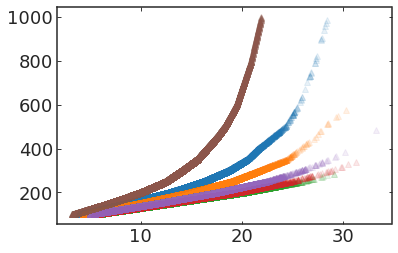

In [109]:
#compute rvs for 
fig, ax=plt.subplots()
for m in MODEL_NAMES:
    predvals=np.vstack(np.vstack(pred_number_dicts[m].values))[:,1]+\
    np.vstack(np.vstack(pred_number_dicts[m].values))[:,2]
    interpf =interp1d(predvals, wispsim.HS)
    rvs=stats.gamma.rvs(NUMBER_OF_OBSERVED_LTS[0], size =int(1e5))
    npoisson=rvs[np.logical_and(rvs>=predvals.min(), rvs <=predvals.max())]
    ltotal_scaleheight.update({m: interpf(npoisson)})
    ax.plot(npoisson, interpf(npoisson), '^', alpha=0.1)
    
#compute rvs for 
for m in MODEL_NAMES:
    predvals=np.vstack(np.vstack(pred_number_dicts[m].values))[:,3]+\
    np.vstack(np.vstack(pred_number_dicts[m].values))[:,4]
    interpf =interp1d(predvals, wispsim.HS)
    rvs=stats.gamma.rvs(NUMBER_OF_OBSERVED_LTS[-1], size =int(1e5))
    npoisson=rvs[np.logical_and(rvs>=predvals.min(), rvs <=predvals.max())]
    ttotal_scaleheight.update({m: interpf(npoisson)})

In [110]:
ltotal_scaleheight.keys()

dict_keys(['burrows1997', 'burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'])

In [111]:
ltotal_scaleheight['combined']=np.concatenate([ltotal_scaleheight[k] \
                                for k in ltotal_scaleheight.keys()])
ttotal_scaleheight['combined']=np.concatenate([ttotal_scaleheight[k] \
                                for k in ttotal_scaleheight.keys()])

In [112]:
ttotal_vdisp={}
ltotal_vdisp={}

ttotal_age_just={}
ttotal_age_aumer={}

ltotal_age_just={}
ltotal_age_aumer={}
for k in ttotal_scaleheight.keys():
    ltotal_vdisp.update({k:scaleheight_to_vertical_disp(ltotal_scaleheight[k])})
    ttotal_vdisp.update({k:scaleheight_to_vertical_disp(ttotal_scaleheight[k])})
    
    ttotal_age_just.update({k: galaxy.avr_just(ttotal_vdisp[k], verbose=False)})
    ttotal_age_aumer.update({k:galaxy.avr_aumer(ttotal_vdisp[k], verbose=False)})
    
    ltotal_age_just.update({k:  galaxy.avr_just(ltotal_vdisp[k], verbose=False)})
    ltotal_age_aumer.update({k:galaxy.avr_aumer(ltotal_vdisp[k], verbose=False)})
    
    

In [113]:
lt_df_h=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])
lt_df_age_aumer=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])
lt_df_age_sharma=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])
#lt_df_age_just=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])
lt_df_v=pd.DataFrame(columns= ttotal_scaleheight.keys(), index=['L', 'T'])

In [114]:
for k in ttotal_scaleheight.keys():
    lt_df_h.loc['L', k]=asssymetric_med_std(ltotal_scaleheight[k])
    lt_df_v.loc['L', k]=asssymetric_med_std(ltotal_vdisp[k])
    lt_df_age_aumer.loc['L', k]=asssymetric_med_std(ltotal_age_aumer[k])
    #lt_df_age_just.loc['L', k]=asssymetric_med_std(ltotal_age_just[k])
    
    lt_df_h.loc['T', k]=asssymetric_med_std(ttotal_scaleheight[k])
    lt_df_v.loc['T', k]=asssymetric_med_std(ttotal_vdisp[k])
    lt_df_age_aumer.loc['T', k]=asssymetric_med_std(ttotal_age_aumer[k])
    #lt_df_age_just.loc['T', k]=asssymetric_med_std(ttotal_age_just[k])

In [115]:
lt_df_h.applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,172.76$ _{-34.88} ^{+50.13}$,157.03$ _{-28.66} ^{+38.42}$,134.46$ _{-20.09} ^{+26.38}$,136.12$ _{-20.85} ^{+27.36}$,142.77$ _{-23.36} ^{+31.6}$,209.95$ _{-51.12} ^{+98.65}$,152.61$ _{-30.24} ^{+56.06}$
T,169.19$ _{-51.93} ^{+140.83}$,171.56$ _{-53.92} ^{+152.46}$,178.14$ _{-58.38} ^{+155.11}$,173.12$ _{-54.76} ^{+139.27}$,182.89$ _{-62.35} ^{+155.08}$,171.38$ _{-53.81} ^{+144.72}$,174.32$ _{-55.83} ^{+148.3}$


In [116]:
lt_df_v.applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,12.6$ _{-1.34} ^{+1.71}$,12.02$ _{-1.15} ^{+1.39}$,11.12$ _{-0.86} ^{+1.04}$,11.19$ _{-0.89} ^{+1.07}$,11.46$ _{-0.98} ^{+1.2}$,13.89$ _{-1.81} ^{+2.95}$,11.85$ _{-1.24} ^{+2.01}$
T,12.47$ _{-2.09} ^{+4.41}$,12.56$ _{-2.16} ^{+4.7}$,12.8$ _{-2.3} ^{+4.71}$,12.62$ _{-2.18} ^{+4.33}$,12.97$ _{-2.44} ^{+4.66}$,12.55$ _{-2.16} ^{+4.5}$,12.66$ _{-2.22} ^{+4.56}$


In [117]:
lt_df_age_aumer.applymap(reformat)

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,2.39$ _{-0.53} ^{+0.79}$,2.15$ _{-0.44} ^{+0.6}$,1.8$ _{-0.3} ^{+0.4}$,1.83$ _{-0.31} ^{+0.42}$,1.93$ _{-0.35} ^{+0.49}$,2.97$ _{-0.8} ^{+1.61}$,2.08$ _{-0.46} ^{+0.88}$
T,2.33$ _{-0.79} ^{+2.28}$,2.37$ _{-0.82} ^{+2.47}$,2.47$ _{-0.89} ^{+2.53}$,2.39$ _{-0.83} ^{+2.25}$,2.55$ _{-0.95} ^{+2.53}$,2.37$ _{-0.82} ^{+2.34}$,2.41$ _{-0.85} ^{+2.41}$


In [118]:
def get_combined_age_lt_simulation():
    comb_dt={'L':[], 'T':[]}
    combined_sim_ages_dict={'L':{}, 'T':{}}
    ks_test_dict_aumer={'L': {}, 'T':{}}
    ks_test_dict_just={'L': {}, 'T':{}}
    for model in tqdm(MODEL_NAMES):
        dfn0=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        ls=dfn0[dfn0.spt.between(20, 29)].age.values
        ts=dfn0[dfn0.spt.between(30, 39)].age.values
        combined_sim_ages_dict['L'].update({model:asssymetric_med_std(ls) })
        combined_sim_ages_dict['T'].update({model:asssymetric_med_std(ts) })
        comb_dt['L'].append(ls)
        comb_dt['T'].append(ts)
         
        kstestt_aumer=stats.ks_2samp(ts, ttotal_age_aumer[model], mode='asymp', alternative='two-sided')[0]
        kstetstl_aumer=stats.ks_2samp(ls, ltotal_age_aumer[model], mode='asymp', alternative='two-sided')[0]
        
        kstestt_just=stats.ks_2samp(ts, ttotal_age_just[model], mode='asymp', alternative='two-sided')[0]
        kstetstl_just=stats.ks_2samp(ls, ltotal_age_just[model], mode='asymp', alternative='two-sided')[0]
        
        ks_test_dict_aumer['L'].update({model: kstetstl_aumer})
        ks_test_dict_aumer['T'].update({model: kstestt_aumer })
        
        ks_test_dict_just['L'].update({model: kstetstl_just})
        ks_test_dict_just['T'].update({model: kstestt_just })
        
        
    
    df=pd.DataFrame.from_records(  combined_sim_ages_dict).T
    df['combined']=[ asssymetric_med_std(np.concatenate(comb_dt['L'])),\
               asssymetric_med_std(np.concatenate(comb_dt['T']))]
    #print (asssymetric_med_std(np.concatenate(comb_dt['L'])))
    #df.loc['L', 'Combined']=asssymetric_med_std(np.concatenate(comb_dt['L']))
    #df.loc['T', 'Combined']=asssymetric_med_std(np.concatenate(comb_dt['T']))
    return df,  ks_test_dict_aumer,  ks_test_dict_just

        
    

In [119]:
simu_ages_lt, lt_ks_tests_aumer, lt_ks_tests_just = get_combined_age_lt_simulation()

100%|█████████████████████████████████████████████| 6/6 [09:58<00:00, 99.68s/it]


In [120]:
simu_ages_lt

,burrows1997,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020,combined
L,"(2.13, [1.57, 3.72])","(2.26, [1.72, 3.78])","(2.34, [1.78, 3.73])","(2.74, [2.13, 3.63])","(2.31, [1.75, 3.77])","(1.59, [1.15, 3.4])","(2.24, [1.7, 3.77])"
T,"(3.55, [2.44, 2.99])","(3.53, [2.41, 3.01])","(3.66, [2.49, 3.0])","(3.59, [2.45, 2.98])","(3.64, [2.48, 2.96])","(3.74, [2.55, 2.95])","(3.62, [2.47, 2.98])"


In [121]:
def print_string_for_lt_only(df, k, roundx=1, use_unc=True):
    res=''
    for m, mshort in zip(np.append(MODEL_NAMES, 'combined'),\
                         np.append(MODEL_SHORT_NAMES, 'Combined')):
        if not use_unc:
            val=df.loc[k,m]
            st= str(round(val, roundx))+r' $&'
        else:
            val, unc=(df.loc[k, m])
            st=str(round(val, roundx))+ '$_{-'+str(round(unc[0], roundx))+'}'\
                + '^{+'+str(round(unc[-1], roundx))+'}'+r' $&'
            if roundx==0:
                st=str(int(round(val, roundx)))+ '$_{-'+str(int(round(unc[0], roundx)))+'}'\
                    + '^{+'+str(int(round(unc[-1], roundx)))+'}'+r' $&'
        res+= st
    return res + r'\\'

In [122]:
print_string_for_lt_only(lt_df_h, 'L', roundx=0)

'173$_{-35}^{+50} $&157$_{-29}^{+38} $&134$_{-20}^{+26} $&136$_{-21}^{+27} $&143$_{-23}^{+32} $&210$_{-51}^{+99} $&153$_{-30}^{+56} $&\\\\'

In [123]:
lt_ks_df_aumer=pd.DataFrame(lt_ks_tests_aumer).T
lt_ks_df_aumer['combined']=[0.0, 0.0]

lt_ks_df_just=pd.DataFrame(lt_ks_tests_just).T
lt_ks_df_just['combined']=[0.0, 0.0]

In [124]:
#lt_ks_df

In [125]:
for k in ['L', 'T']:
    print (k + r'&$H$ (pc) &' + print_string_for_lt_only(lt_df_h, k, roundx=0) )
    print (r' & $\sigma_w$ (km/s)  &' + print_string_for_lt_only(lt_df_v, k, roundx=1))
    #print (r' & Age (Gyr) (J10) &' +print_string_for_lt_only(lt_df_age_just, k, roundx=1))
    print (r' & Age (Gyr) (A09) &' + print_string_for_lt_only(lt_df_age_aumer, k, roundx=1))
    print (r' & Median Age (Gyr) (Simulation)&' +print_string_for_lt_only(simu_ages_lt, k, roundx=1))
    print (r' & KS (A09-Simulation) & ' +print_string_for_lt_only(lt_ks_df_aumer, k,  roundx=1, use_unc=False))
    #print (r' & KS (J10-Simulation) & ' +print_string_for_lt_only(lt_ks_df_just, k,  roundx=1, use_unc=False))
    #print ('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

    



L&$H$ (pc) &173$_{-35}^{+50} $&157$_{-29}^{+38} $&134$_{-20}^{+26} $&136$_{-21}^{+27} $&143$_{-23}^{+32} $&210$_{-51}^{+99} $&153$_{-30}^{+56} $&\\
 & $\sigma_w$ (km/s)  &12.6$_{-1.3}^{+1.7} $&12.0$_{-1.2}^{+1.4} $&11.1$_{-0.9}^{+1.0} $&11.2$_{-0.9}^{+1.1} $&11.5$_{-1.0}^{+1.2} $&13.9$_{-1.8}^{+3.0} $&11.8$_{-1.2}^{+2.0} $&\\
 & Age (Gyr) (A09) &2.4$_{-0.5}^{+0.8} $&2.2$_{-0.4}^{+0.6} $&1.8$_{-0.3}^{+0.4} $&1.8$_{-0.3}^{+0.4} $&1.9$_{-0.4}^{+0.5} $&3.0$_{-0.8}^{+1.6} $&2.1$_{-0.5}^{+0.9} $&\\
 & Median Age (Gyr) (Simulation)&2.1$_{-1.6}^{+3.7} $&2.3$_{-1.7}^{+3.8} $&2.3$_{-1.8}^{+3.7} $&2.7$_{-2.1}^{+3.6} $&2.3$_{-1.8}^{+3.8} $&1.6$_{-1.2}^{+3.4} $&2.2$_{-1.7}^{+3.8} $&\\
 & KS (A09-Simulation) & 0.4 $&0.3 $&0.4 $&0.5 $&0.4 $&0.5 $&0.0 $&\\
T&$H$ (pc) &169$_{-52}^{+141} $&172$_{-54}^{+152} $&178$_{-58}^{+155} $&173$_{-55}^{+139} $&183$_{-62}^{+155} $&171$_{-54}^{+145} $&174$_{-56}^{+148} $&\\
 & $\sigma_w$ (km/s)  &12.5$_{-2.1}^{+4.4} $&12.6$_{-2.2}^{+4.7} $&12.8$_{-2.3}^{+4.7} $&12.6$

In [126]:
(124*4.8)*0.12

71.42399999999999

In [127]:
len(ucds)

164

In [ ]:
#just ages themselves 

In [128]:
FGHJ

NameError: name 'FGHJ' is not defined

In [ ]:
VOLUMESF110=np.nansum(volumes.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)

In [ ]:
cnorm=Normalize(wispsim.HS[0], (wispsim.HS[-1]))

In [ ]:
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in enumerate(wispsim.HS):
    #plt.plot(wispsim.SPGRID, np.log10(OLDERVOLUMES[idx]), color=cmap(cnorm(h/100)),
     #   linewidth=3, linestyle='--', alpha=0.3)
    
    plt.plot(wispsim.SPGRID, np.log10(VOLUMES[idx]), color=cmap(cnorm(h)),
             linewidth=3, label=r'h ={} pc'.format(h), linestyle='-')

#plt.plot(wispsim.SPGRID, np.log10(vsunif), label=r'd$^3$' )
plt.ylabel(r'Log  Veff', fontsize=18)
plt.xlabel('SpT', fontsize=18)
#plt.legend(fontsize=14)
cax = fig.add_axes([.3, 0.4, .3, 0.03])
mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel(r' H (pc)', fontsize=18)
cax.minorticks_on()
plt.minorticks_on()
#plt.grid(which='both')

plt.tight_layout()
ax.set_xticks([20, 25, 30, 35, 40])
ax.set_xticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_volumes.pdf', bbox_inches='tight')

In [ ]:
steps=np.arange(len(pnts))
AREA=4.1*(u.arcmin**2).to(u.radian**2)


In [ ]:
np.shape(volumes[:,  ])
import splat

In [ ]:
fig, ((ax, ax1), (ax2, ax3))=plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
for idx, h in enumerate(wispsim.HS):
    ax.step(steps, np.log10(np.cumsum(volumes[:, idx, 0])*AREA), color=cmap(cnorm(h)), linewidth=3)
    ax1.step(steps, np.log10(np.cumsum(volumes[:,idx, 9])*AREA), color=cmap(cnorm(h)), linewidth=3)
    ax2.step(steps, np.log10(np.cumsum(volumes[:,idx, -6])*AREA), color=cmap(cnorm(h)), linewidth=3)
    ax3.step(steps, np.log10(np.cumsum(volumes[:, idx, -1])*AREA), color=cmap(cnorm(h)), linewidth=3, label=r'h ={}'.format(h))



#ax2.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)

for a in [ax, ax1, ax2, ax3]:
    a.set_xlabel('Number of Pointings', fontsize=18)
    a.minorticks_on()
    a.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)
    
ax.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[0])), fontsize=18)
ax1.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[9])), fontsize=18)
ax2.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-6])), fontsize=18)
ax3.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-1])), fontsize=18)

#ax3.legend(fontsize=15)
cax = fig.add_axes([.6, 0.2, .3, 0.03])
mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap)
cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel(r' H (pc)', fontsize=18)
cax.minorticks_on()

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/cumulative_volumes.pdf', bbox_inches='tight')

In [ ]:
LIT_SCALEHEIGHT={'ryan05': {'h': 350, 'her': 50, 'spt':[16, 19]},\
                 'pirzkal09':{'h': 370, 'her':60, 'spt':[14, 19]}, \
                 'holder14': {'h': 400, 'her':100 , 'spt':[15, 19]},\
                 'bochanski':{'h':300, 'her':15, 'spt': [10, 18]},\
                 'vanVledder':{'h': 290, 'her':20, 'spt':[10, 19]}, \
                 'ryan2016' :{'h':350, 'her':50, 'spt':[10, 19]},\
                 'carnero': {'h': 450 , 'her':0, 'spt':[20, 40]}}

LIT_VELOCITY={'burgasser2015m': {'val':  13.8,  'er': 0.3, 'spt':[17, 19]},\
              'burgasser2015l':{'val': 19.5 , 'er': 0.4, 'spt':[20, 24]},\
            'hsu2021m':{'val': 16.3 , 'er':0.3, 'spt':[17, 19]}, \
            'hsu2021l': {'val':  15.3, 'er':0.3 , 'spt':[20, 29]},\
            'hsu2021t': {'val': 13.3, 'er': 0.4, 'spt':[30, 40]}}

MY_SCALEHEIGHT={'m':{'h': 395, 'her':[144, 94], 'spt':[17, 19] }, \
                'l':{'h': 193, 'her':[41, 96], 'spt':[20, 29] },\
                't':{'h': 237, 'her':[98, 248], 'spt':[30, 40] }}

MY_VELOCITY={'m':{'val': 19.9, 'er':[3.9,2.1], 'spt':[17, 19] }, \
                'l':{'val': 13.3, 'er':[1.5, 3.0], 'spt':[20, 29] },\
                't':{'val': 14.7, 'er':[3.5, 6.4], 'spt':[30, 40] }}

In [ ]:
fig, ax=plt.subplots(figsize=(8, 6))
for k in LIT_SCALEHEIGHT.keys():
    sperr=[np.nanmedian(LIT_SCALEHEIGHT[k]['spt'])-LIT_SCALEHEIGHT[k]['spt'][0],\
          LIT_SCALEHEIGHT[k]['spt'][1]-np.nanmedian(LIT_SCALEHEIGHT[k]['spt'])]
    
    ax.errorbar(np.nanmedian(LIT_SCALEHEIGHT[k]['spt']), LIT_SCALEHEIGHT[k]['h'],\
                fmt='o', color='#111111', yerr= LIT_SCALEHEIGHT[k]['her'], \
               xerr=np.vstack(sperr))

    
for k in MY_SCALEHEIGHT:
    sperr= [np.nanmedian(MY_SCALEHEIGHT[k]['spt'])-MY_SCALEHEIGHT[k]['spt'][0],\
    MY_SCALEHEIGHT[k]['spt'][-1]-np.nanmedian(MY_SCALEHEIGHT[k]['spt'])]
    ax.errorbar(np.nanmedian(MY_SCALEHEIGHT[k]['spt']), MY_SCALEHEIGHT[k]['h'], fmt='o', \
                color='#01FF70', ms=10, lw=5, capsize=5, \
                xerr=np.vstack(sperr), yerr=np.vstack(MY_SCALEHEIGHT[k]['her']), \
                )

ax.set_ylabel('Scaleheight (pc)', fontsize=18)
ax.set_xlabel('Spectral Type', fontsize=18)
ax.minorticks_on()

ax.set_xticks([15, 20, 25, 30, 35, 40])
ax.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])

#ax.legend()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/scale_height_literature.pdf', 
            bbox_inches='tight',   facecolor='black', transparent=False)
    

In [ ]:
fig, ax=plt.subplots(figsize=(8, 6))
for k in LIT_VELOCITY.keys():
    sperr=[np.nanmedian(LIT_VELOCITY[k]['spt'])-LIT_VELOCITY[k]['spt'][0],\
          LIT_VELOCITY[k]['spt'][1]-np.nanmedian(LIT_VELOCITY[k]['spt'])]
    
    ax.errorbar(np.nanmedian(LIT_VELOCITY[k]['spt']), LIT_VELOCITY[k]['val'],\
                fmt='o', color='#111111', yerr= LIT_VELOCITY[k]['er'], \
               xerr=np.vstack(sperr))

    
for k in MY_SCALEHEIGHT:
    sperr= [np.nanmedian(MY_VELOCITY[k]['spt'])-MY_VELOCITY[k]['spt'][0],\
    MY_VELOCITY[k]['spt'][-1]-np.nanmedian(MY_VELOCITY[k]['spt'])]
    ax.errorbar(np.nanmedian(MY_VELOCITY[k]['spt'])+0.5, MY_VELOCITY[k]['val'], fmt='o', \
                color='#01FF70', ms=10, lw=5, capsize=5, \
                xerr=np.vstack(sperr), yerr=np.vstack(MY_VELOCITY[k]['er']), \
                )

ax.set_ylabel('Vertical velocity dispersion (km/s)', fontsize=18)
ax.set_xlabel('Spectral Type', fontsize=18)
ax.minorticks_on()

ax.set_xticks([15, 20, 25, 30, 35, 40])
ax.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])

#ax.legend()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/velocity_literature.pdf', 
            bbox_inches='tight',   facecolor='black', transparent=False)
    

In [ ]:
cands[cands.spt>35].spectra.iloc[0].grism_id

In [ ]:
124*4.4